## Deriving Stress Labels

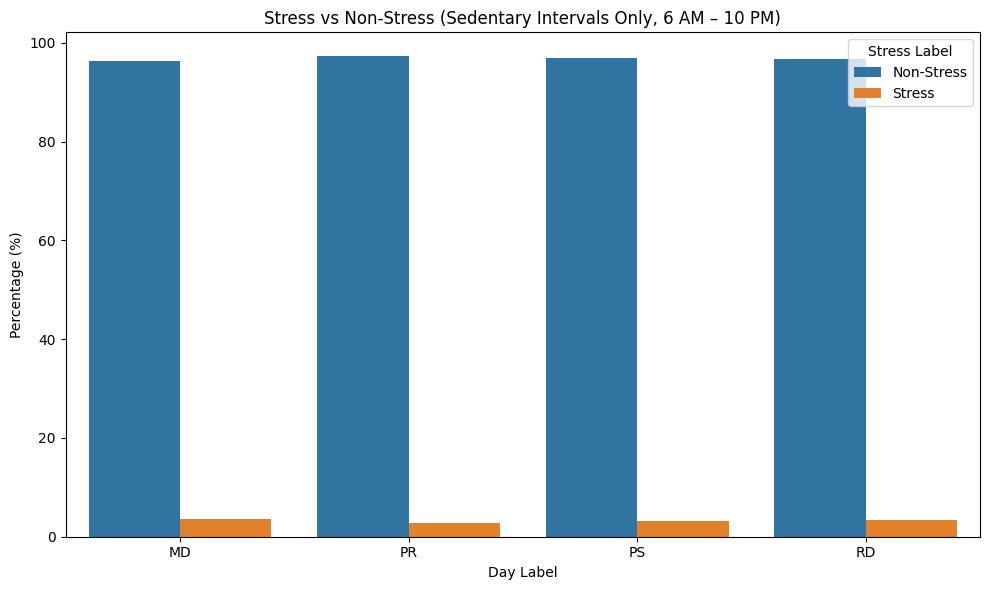

In [2]:
# 📦 Step 1: Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 📂 Step 2: Load your dataset
df = pd.read_csv("All_Curated_Demog_Activity_Sleep5_min_N23_with_Activity_Pred_RF.csv")

# ⏰ Step 3: Parse 'Time' column and extract hour (handles mixed formats)
df['Time'] = pd.to_datetime(df['Time'], format='mixed', errors='coerce')
df['Hour'] = df['Time'].dt.hour

# 🕒 Step 4: Filter between 6 AM and 10 PM only
df_daytime = df[(df['Hour'] >= 6) & (df['Hour'] < 22)]

# 🪑 Step 5: Filter for sedentary rows only
df_sedentary = df_daytime[df_daytime['Activity_Pred_RF'].str.lower() == 'sedentary'].copy()

# 📊 Step 6: Compute mean and std of HR_Normalized per participant per day label
thresholds = (
    df_sedentary
    .groupby(['ID', 'Day_label'])['HR_Normalized']
    .agg(['mean', 'std'])
    .reset_index()
    .rename(columns={'mean': 'nhr_mean', 'std': 'nhr_std'})
)

# 🔗 Step 7: Merge stats back into sedentary dataframe
df_sedentary = df_sedentary.merge(thresholds, on=['ID', 'Day_label'], how='left')

# 🧠 Step 8: Label as Stress if HR_Normalized > mean + 2*std
df_sedentary['Stress_Label_NHR'] = np.where(
    df_sedentary['HR_Normalized'] > (df_sedentary['nhr_mean'] + 2 * df_sedentary['nhr_std']),
    'Stress',
    'Non-Stress'
)

# 🧩 Step 9: Add the labels back to the main dataframe
df['Stress_Label_NHR'] = None
df.loc[df_sedentary.index, 'Stress_Label_NHR'] = df_sedentary['Stress_Label_NHR']

# 📈 Step 10: Plot percentage of Stress vs Non-Stress by Day_label
plot_df = df[df['Stress_Label_NHR'].notna()]
stress_counts = (
    plot_df
    .groupby(['Day_label', 'Stress_Label_NHR'])
    .size()
    .reset_index(name='count')
)

# Convert to percentages
stress_counts['percent'] = stress_counts.groupby('Day_label')['count'].transform(lambda x: 100 * x / x.sum())

# 🎨 Step 11: Bar plot
plt.figure(figsize=(10, 6))
sns.barplot(data=stress_counts, x='Day_label', y='percent', hue='Stress_Label_NHR')
plt.title("Stress vs Non-Stress (Sedentary Intervals Only, 6 AM – 10 PM)")
plt.ylabel("Percentage (%)")
plt.xlabel("Day Label")
plt.legend(title="Stress Label")
plt.tight_layout()
plt.show()
